<a href="https://colab.research.google.com/github/perpk/BNP-57-GE1/blob/main/BNP_57_GE1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ΒΝΠ 57 - Πρωτεομική, Γενωμική και Γονιδιοματική
___
### 1η Γραπτή εργασία
Κωνσταντίνος Περπερίδης

## Ανάλυση διαφορικής έκφρασης [GSE279069](https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE279069)

In [ ]:
if (!require("BiocManager", quietly = TRUE))
  install.packages("BiocManager")
install.packages("dplyr")
install.packages("tidyverse")
install.packages("janitor")
install.packages("pheatmap")
install.packages("ggrepel")

BiocManager::install("GEOquery")
BiocManager::install("DESeq2")
BiocManager::install("biomaRt")
BiocManager::install("clusterProfiler")
BiocManager::install("WGCNA")

BiocManager::install("org.Hs.eg.db")




Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependency ‘snakecase’


Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

'getOption("repos")' replaces Bioconductor standard repositories, see
'help("repositories", package = "BiocManager")' for details.
Replacement repositories:
    CRAN: https://cran.rstudio.com

Bioconductor version 3.19 (BiocManager 1.30.25), R 4.4.1 (2024-06-14)

Installing package(s) 'BiocVersion', 'GEOquery'

also installing the dependencies ‘BiocGenerics’, ‘statmod’, ‘R.oo’, ‘R.methodsS3’, ‘Biobase’, ‘limma’, ‘R.utils’


Old packages: 'gtable'

'getO

In [ ]:
library(dplyr)
library(DESeq2)
library(ggplot2)
library(GEOquery)
library(ggrepel)
library(WGCNA)
library(clusterProfiler)
library(org.Hs.eg.db)

### Ανάγνωση αρχείου και κανονικοποίηση με z-scale

In [ ]:
ards <- read.table("GSE279069_allsample_featurecount.txt.gz", header=TRUE, sep = "\t", comment.char = "!")
gse <- getGEO("GSE279069")
diagnosis <- gse[[1]]$`genotype:ch1`

temp <- ards[,-1]
rownames(temp) <- ards$Geneid
ards <- data.frame(temp)

ards_norm <- apply(X = ards, MARGIN=2, FUN=scale)

ards_norm_fn <- function(df) {
  df_norm <- apply(X=df, MARGIN=2, FUN=scale)
  colnames(df_norm) <- colnames(df)
  rownames(df_norm) <- rownames(df)
  return(df_norm)
}

ards_norm = ards_norm_fn(ards)


Found 1 file(s)

GSE279069_series_matrix.txt.gz

Using locally cached version: /tmp/Rtmpwa8Vcv/GSE279069_series_matrix.txt.gz

Using locally cached version of GPL21697 found here:
/tmp/Rtmpwa8Vcv/GPL21697.soft.gz 



### Εκτέλεση ανάλυσης διαφορικής έκφρασης

Warning message in DESeqDataSet(se, design = design, ignoreRank):
“some variables in design formula are characters, converting to factors”
estimating size factors

estimating dispersions

gene-wise dispersion estimates

mean-dispersion relationship

final dispersion estimates

fitting model and testing

-- replacing outliers and refitting for 4900 genes
-- DESeq argument 'minReplicatesForReplace' = 7 
-- original counts are preserved in counts(dds)

estimating dispersions

fitting model and testing



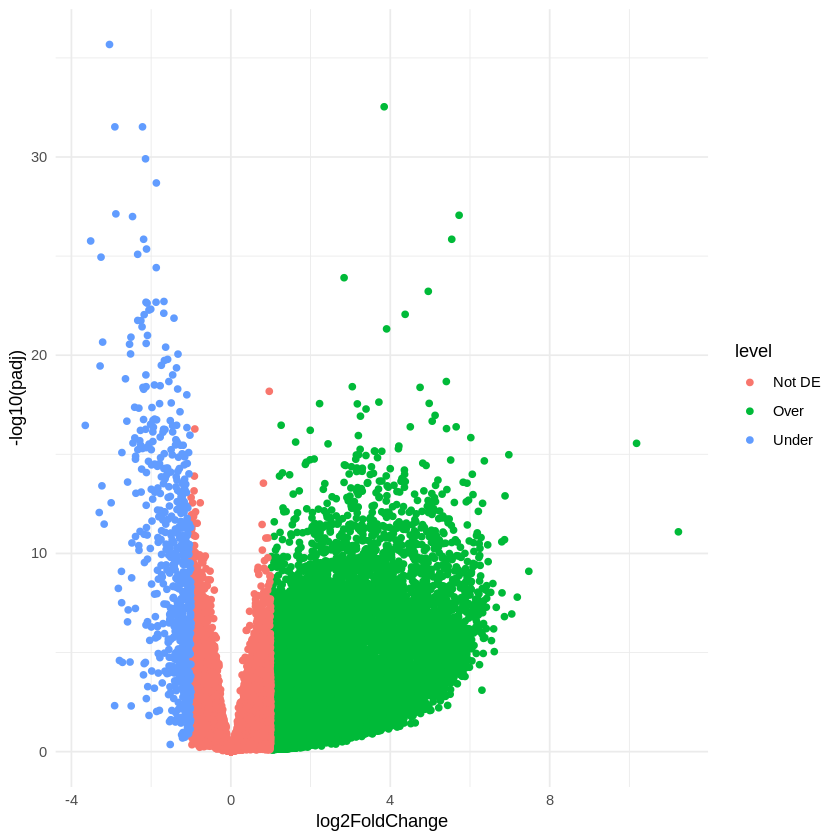

In [ ]:
ards_t <- as.data.frame(t(ards_norm))
ards_d <- cbind(ards_t, diagnosis)

deseq <- DESeqDataSetFromMatrix(ards, data.frame(diagnosis), ~ diagnosis)
deseq <- DESeq(deseq)

deseq_results <- results(deseq, contrast = c("diagnosis", "ARDS", "nonARDS"))
deseq_results_df <- data.frame(deseq_results)

non_na <- !is.na(deseq_results_df$padj)
deseq_results_df <- deseq_results_df[non_na, ]
deseq_results_df <- deseq_results_df[order(-deseq_results_df$log2FoldChange, deseq_results_df$padj),]

plot_df <- deseq_results_df
plot_df$level <- "Not DE"
plot_df$level[plot_df$log2FoldChange >= 1] <- "Over"
plot_df$level[plot_df$log2FoldChange <= -1] <- "Under"
colours <- c("Over" = "#de28c3", "Not DE" = "#b7de28", "Under" = "#369bba")
sizes <- c("Over" = 1, "Not DE" = 0.7, "Under" = 1)
alphas <- c("Over" = 0.5, "Not DE" = 0.1, "Under" = 0.5)
ggplot(data=plot_df, aes(x=log2FoldChange, y=-log10(padj), col=level)) + geom_point() + theme_minimal()
deseq_results_df <- deseq_results_df[abs(deseq_results_df$log2FoldChange >= 1) & deseq_results_df$padj < 0.05,]


### Ανάλυση WGCNA

In [ ]:
ards_de <- ards_t[rownames(ards_norm) %in% rownames(deseq_results_df)]

powers = c(1:20)
sft = pickSoftThreshold(ards_de, powerVector=powers, verbose=5)


pickSoftThreshold: will use block size 5020.
 pickSoftThreshold: calculating connectivity for given powers...
   ..working on genes 1 through 5020 of 8912
   ..working on genes 5021 through 8912 of 8912
   Power SFT.R.sq   slope truncated.R.sq mean.k. median.k. max.k.
1      1   0.8720  1.4100          0.846    4500    5150.0   6030
2      2   0.4160  0.4000          0.459    3010    3480.0   4810
3      3   0.0201  0.0618          0.204    2250    2490.0   4090
4      4   0.0786 -0.1240          0.328    1780    1830.0   3600
5      5   0.2750 -0.2650          0.665    1460    1380.0   3230
6      6   0.4030 -0.3530          0.817    1230    1060.0   2940
7      7   0.4810 -0.4080          0.851    1060     820.0   2700
8      8   0.5420 -0.4610          0.849     922     644.0   2510
9      9   0.6040 -0.5000          0.840     813     510.0   2350
10    10   0.6520 -0.5370          0.823     723     409.0   2210
11    11   0.6840 -0.5700          0.802     649     332.0   2090
12   

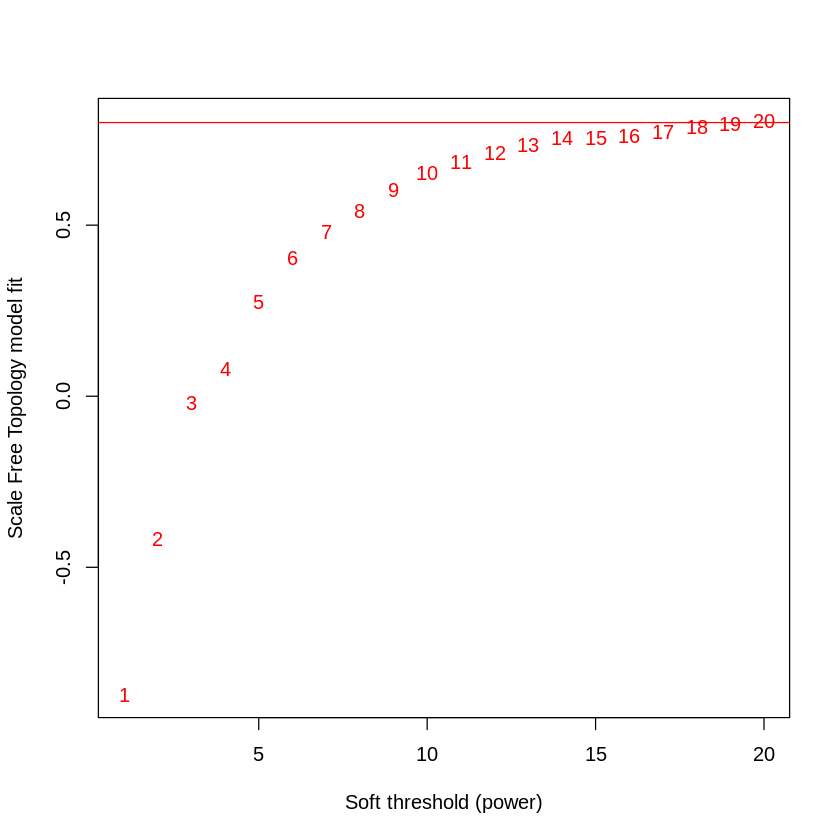

In [ ]:
plot(sft$fitIndices[,1], -sign(sft$fitIndices[,3])*sft$fitIndices[,2], type="n", xlab="Soft threshold (power)", ylab="Scale Free Topology model fit")
text(sft$fitIndices[,1], -sign(sft$fitIndices[,3])*sft$fitIndices[,2], labels=powers, col="red")
abline(h=0.8, col="red")


[conflicted] Will prefer WGCNA::cor over any other package.


..connectivity..
..matrix multiplication (system BLAS)..
..normalization..
..done.


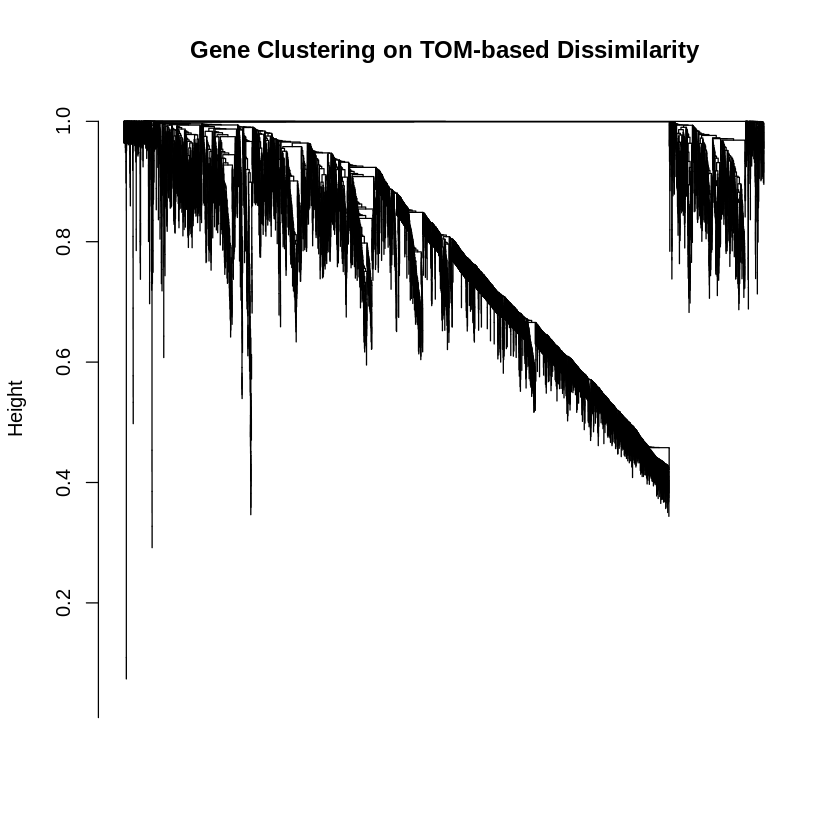

In [ ]:
library(conflicted)

softPower = 20
conflicts_prefer(WGCNA::cor)
adjacency = adjacency(ards_de, power = softPower)

TOM = TOMsimilarity(adjacency)
dissTOM = 1 - TOM

geneTree = hclust(as.dist(dissTOM), method = "average")
plot(geneTree, xlab="", sub="", main="Gene Clustering on TOM-based Dissimilarity", labels=FALSE, hang=0.04)

 ..cutHeight not given, setting it to 0.995  ===>  99% of the (truncated) height range in dendro.
 ..done.


dynamicMods
   0    1    2    3    4    5    6    7    8    9   10   11   12   13   14   15 
 823 3694  441  434  429  350  331  289  243  239  238  237  195  163  150  122 
  16   17   18   19   20   21   22 
 105   95   85   85   67   52   45 

dynamicColors
       black         blue        brown         cyan    darkgreen      darkred 
         289          441          434          150           45           52 
       green  greenyellow         grey       grey60    lightcyan   lightgreen 
         350          237          823           95          105           85 
 lightyellow      magenta midnightblue         pink       purple          red 
          85          239          122          243          238          331 
   royalblue       salmon          tan    turquoise       yellow 
          67          163          195         3694          429 

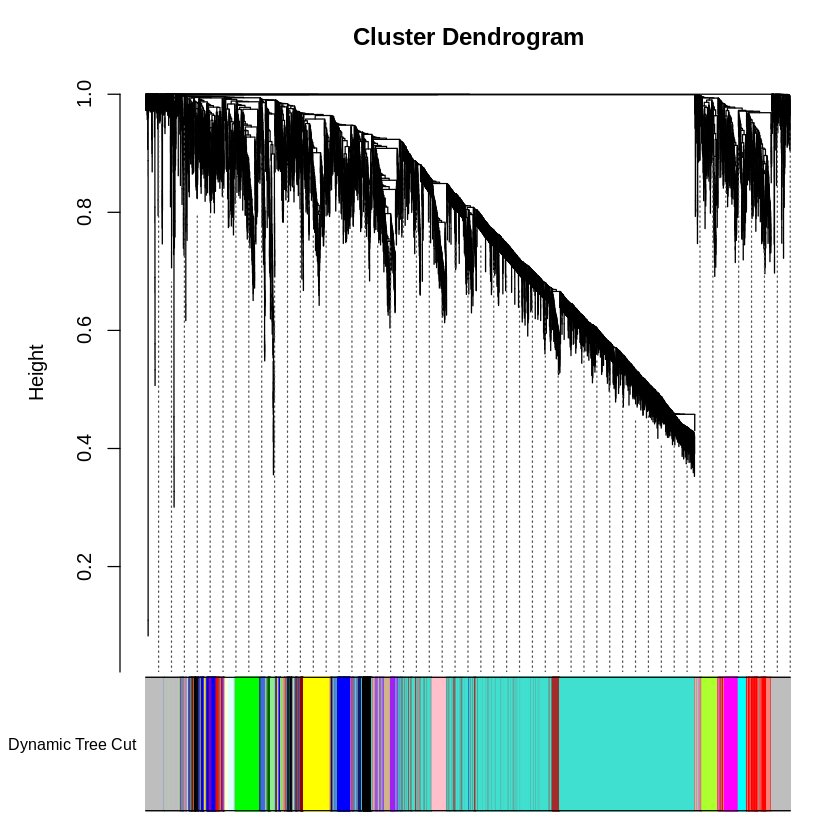

In [ ]:
dynamicMods = cutreeDynamic(dendro = geneTree, distM = dissTOM, deepSplit = 2, pamRespectsDendro = FALSE, minClusterSize = 30)
table(dynamicMods)

dynamicColors = labels2colors(dynamicMods)
table(dynamicColors)

plotDendroAndColors(geneTree, dynamicColors, "Dynamic Tree Cut", dendroLabels = FALSE, hang = 0.03, addGuide = TRUE, guideHang = 0.05)


In [ ]:
MEList = moduleEigengenes(ards_de, colors = dynamicColors)
MEs = MEList$eigengenes

moduleMembership = cor(ards_de, MEs, use = "pairwise.complete.obs")
moduleColors = dynamicColors


### Εξόρυξη δεδομένων σχετικά με φαινότυπο απο τις WGCNA ομάδες

Εξαγωγή ομάδων γονιδίων για τα οποία εικάζεται συντονισμένη έκφραση μετά απο εκτέλεση WGCNA σε MS Excel αρχεία. Τα δεδομένα αυτών των αρχείων χρησιμοποιήθηκαν για την ανάλυση εμπλουτισμού μέσω GeneCodis.

In [ ]:
install.packages("hash")
library(stringr)
library(hash)

hubGenes <- c()
h <- hash()
for (group in colnames(moduleMembership)) {
  modGenes = (moduleColors == group %>% str_replace("ME",""))
  hubGene = names(which.max(moduleMembership[modGenes, group]))
  genes_in_group <- names(moduleMembership[modGenes, group])
  cat("Length for group", group, "=", length(genes_in_group), "__ ")
  h[[group]] <- names(moduleMembership[modGenes, group])
  cat("Hub gene for module", group, ":", hubGene, "\n")
  hubGenes <- c(hubGenes, hubGene)
  write_xlsx(data.frame(genes_in_group), sprintf("./%s.xlsx", group))
}


Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



Length for group MEblack = 289 __ Hub gene for module MEblack : GABRA5 
Length for group MEblue = 441 __ Hub gene for module MEblue : ANKRD20A8P 
Length for group MEbrown = 434 __ Hub gene for module MEbrown : C1orf105 
Length for group MEcyan = 150 __ Hub gene for module MEcyan : COL5A3 
Length for group MEdarkgreen = 45 __ Hub gene for module MEdarkgreen : LINC00941 
Length for group MEdarkred = 52 __ Hub gene for module MEdarkred : ANKLE1 
Length for group MEgreen = 350 __ Hub gene for module MEgreen : TBX4 
Length for group MEgreenyellow = 237 __ Hub gene for module MEgreenyellow : UBE2QL1 
Length for group MEgrey = 823 __ Hub gene for module MEgrey : EPN3 
Length for group MEgrey60 = 95 __ Hub gene for module MEgrey60 : PRR35 
Length for group MElightcyan = 105 __ Hub gene for module MElightcyan : THY1 
Length for group MElightgreen = 85 __ Hub gene for module MElightgreen : LINC00837 
Length for group MElightyellow = 85 __ Hub gene for module MElightyellow : ZIC4 
Length for grou

Ανάλυση εμπλουτισμού μέσω R έναντι GO_BP, GO_CC, GO_MF και φίλτρο για σχολιασμό σχετικά με βιοχημικά και φαινοτυπικά χαρακτηριστικά ανοσολογικής απόκρισης, φλεγμωνής και οπτικοποίηση μέσω heatmap.

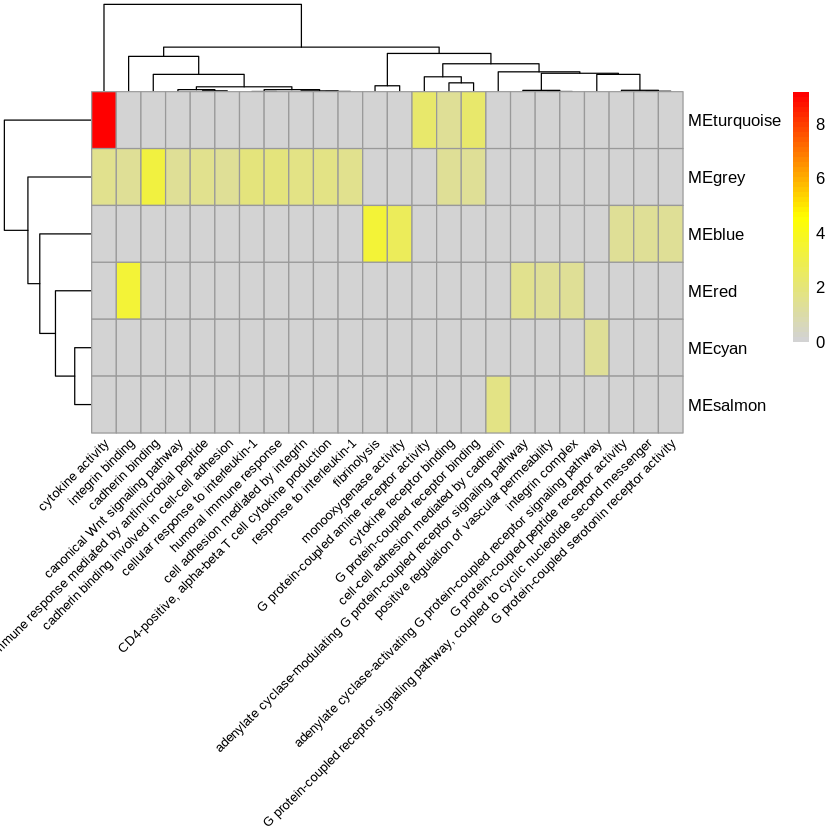

In [ ]:
enrich <- list()
for (group in colnames(moduleMembership)) {
  modGenes = (moduleColors == group %>% str_replace("ME",""))
  genes_in_group <- names(moduleMembership[modGenes, group])
  GO <- enrichGO(gene = genes_in_group, OrgDb=org.Hs.eg.db, keyType="SYMBOL", ont="ALL", pAdjustMethod="BH")
  GO_f <- GO[grep("inflammation|immune|cytokine|cadherin|wnt|fibrinolysis|monooxygenase|G protein|pulmonary|integrin|aldosterone|interleukin|cytosine|permeability", GO$Description, ignore.case=TRUE), ]
  enrich[[group]] <- GO_f
}
module_names <- colnames(moduleMembership)
terms <- unique(unlist(lapply(enrich, function(e) e$Description)))
data <- matrix(0, nrow=length(module_names), ncol=length(terms), dimnames=list(module_names, terms))

for (mod in module_names) {
  term <- enrich[[mod]]$Description
  data[mod, term] <- -log10(enrich[[mod]]$p.adjust)
}

library(pheatmap)
data_filtered <- data[apply(data, 1, function(x) !all(x==0)),]

pheatmap(data_filtered, color=colorRampPalette(c("lightgray", "yellow", "red"))(50), cluster_rows = TRUE, cluster_cols=TRUE, display_numbers=FALSE, fontsize_col = 8, fontsize_row = 10, fontsize_number = 10, angle_col = 45)


Μέσω αποτελεσμάτων απο ανάλυση εμπλουτισμού έναντι περισσοτερων οντολογιών μέσω GeneCodis (GO_BP, GO_CC, GO_MF, KEGG, PANTHER, Reactome, OMIM, HPO) φίλτρο σε σχετικούς όρους και εξαγωγή αποτελεσμάτων.

In [ ]:

library(tidyverse)
all_enriched_turqoise <- list.files(path="./", pattern="*input1*.tsv") %>% map_df(~read_tsv(.) %>% mutate(annotation_id = as.character(annotation_id)))
filtered_cytokine <- dplyr::filter(all_enriched_turqoise, grepl("cytokine|pulmonar|breath", description))
filtered_cytokine <- filtered_cytokine[filtered_cytokine$pval_adj < 0.05,]
write_xlsx(filtered_cytokine, "./cytokine_turqoise.xlsx")

all_enriched_grey <- list.files(path="./", pattern="*nput2-*") %>% map_df(~read_tsv(.) %>% mutate(annotation_id = as.character(annotation_id)))
all_enriched_grey <- all_enriched_grey[order(all_enriched_grey$pval_adj),]
filtered_grey_immune <- dplyr::filter(all_enriched_grey, grepl("breath|pulmonar|respirator", description))
filtered_grey_immune <- filtered_grey_immune[filtered_grey_immune$pval_adj < 0.05,]
write_xlsx(filtered_grey_immune, "./respiratory_grey.xlsx")